## Imports

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from pmlb import classification_dataset_names, regression_dataset_names
import numpy as np
from sklearn import datasets
from JOPLEn.singletask import JOPLEn
from JOPLEn.enums import *
from sklearn.ensemble import (
    ExtraTreesRegressor,
    ExtraTreesClassifier,
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
    AdaBoostRegressor,
    AdaBoostClassifier,
)
from sklearn.linear_model import LinearRegression
from lineartree import (
    LinearForestRegressor,
    LinearForestClassifier,
    LinearBoostRegressor,
    LinearBoostClassifier,
)
from xgboost import XGBRegressor, XGBClassifier
from JOPLEn.ablation import Booster
import lineartree as lt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor, DummyClassifier
from itertools import product
import warnings
from collections import defaultdict
from linear_operator.utils.warnings import NumericalWarning
from sklearn.linear_model import Ridge, RidgeClassifier

# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
# Hide unfixable warning from ax (warns about default behavior but there isn't
# a clear way to turn the warning off)
warnings.simplefilter(action="ignore", category=UserWarning)
# Ax gives warning about non PSD matrix.
# TODO: Should I fix this?
warnings.simplefilter(action="ignore", category=NumericalWarning)
from ax import optimize
from pathlib import Path
from copy import copy, deepcopy
import yaml
import time
from pprint import pprint
from ax.service.ax_client import AxClient, ObjectiveProperties
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER
from JOPLEn.partitioner import (
    VPartition,
    GBPartition,
    RFPartition,
    VarMaxForestPartition,
    LinearForestPartition,
    LinearBoostPartition,
)
from JOPLEn.singletask import SquaredError, LogisticLoss
from JOPLEn.enums import CellModel
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from nn import NN
from sklearn.metrics import log_loss, roc_auc_score, zero_one_loss
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import OrdinalEncoder

import sys

fastel_path = Path().resolve().parent
sys.path.append(str(fastel_path))

from FASTEL.src.engine import MultiTaskTrees
from sklearn.preprocessing import LabelEncoder

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)

CACHE_DIR = Path("ax_runs") / "prediction"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

DS_PATH = (Path("..") / "datasets" / "pmlb" / "processed").resolve()
PARAM_PATH = (Path(".") / "parameters").resolve()
PLOT_PATH = (Path(".") / "plots").resolve()

2024-03-15 23:50:39.395834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 23:50:39.395855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 23:50:39.396475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# too many samples, causes JOPLEn to crash
EXCLUDE = [
    # regression
    "1191_BNG_pbc",
    "215_2dplanes",
    "1201_BNG_breastTumor",
    "1196_BNG_pharynx",
    "1595_poker",
    "1203_BNG_pwLinear",
    "594_fri_c2_100_5",
    "218_house_8L",
    "1193_BNG_lowbwt",
    "537_houses",
    "564_fried",
    "344_mv",
    "574_house_16H",
    "573_cpu_act",
    "562_cpu_small",
    "1199_BNG_echoMonths",
    "294_satellite_image",
    "197_cpu_act",
    "201_pol",
    "227_cpu_small",
    "503_wind",
    # classification
    # "Hill_Valley_with_noise",
    # "Hill_Valley_without_noise",
    # "breast_cancer_wisconsin",
    # "appendicitis",
    # "prnn_synth",
    # "sonar",
    # "phoneme",
    # "twonorm",
    # "magic",
    # "wdbc",
    "adult",
    # crashing for some reason, fix later
    "Hill_Valley_without_noise",
]

## Parameters

In [3]:
model_info = {
    "reg": {},
    "class": {},
}

for t in ["reg", "class"]:
    for model in (PARAM_PATH / t).glob("*.yaml"):
        model_info[t][model.stem] = yaml.safe_load(open(model, "r"))

## Training Functions

In [4]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def auc(y_true, y_pred):
    if len(set(y_true)) == 2:
        return float(roc_auc_score(y_true, y_pred))
    else:
        return None


def convert_to_ordinals(feature_type, x_train, x_val, x_test):
    cat_idxs = np.array(
        [i for i, t in enumerate(feature_type) if t in ["categorical", "binary"]]
    )

    if len(cat_idxs) > 0:
        # lgbm doesn't like negative values for categorical values. Technically
        # negative indicates that the value is actually quantized scalar, but
        # PMLB doesn't distinguish these from regular categorical values.
        x_train = x_train.copy()
        x_val = x_val.copy()

        enc = OrdinalEncoder().fit(x_train[:, cat_idxs])

        x_train[:, cat_idxs] = enc.transform(x_train[:, cat_idxs])
        x_val[:, cat_idxs] = enc.transform(x_val[:, cat_idxs])

        if x_test is not None:
            x_test = x_test.copy()
            x_test[:, cat_idxs] = enc.transform(x_test[:, cat_idxs])

    return cat_idxs, x_train, x_val, x_test


def loss(
    y_true: np.ndarray, y_pred: np.ndarray, loss_str: str
) -> tuple[float, dict[str, float]]:
    if loss_str in ["mse", "rmse", "regression", False, "reg:squarederror"]:
        return float(rmse(y_true, y_pred)), {}
    elif loss_str in ["log_loss", "binary", True, "reg:logistic"]:
        y_class_pred = (y_pred > 0.5).astype(int)

        return float(log_loss(y_true, y_pred)), {
            "auc": float(roc_auc_score(y_true, y_pred)),
            "zo_loss": float(zero_one_loss(y_true, y_class_pred)),
        }
    else:
        raise ValueError(f"Unknown loss function: {loss_str}")


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time

        return (result, start_time, end_time, elapsed_time)

    return wrapper


@timer_decorator
def train_lgbm(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    params = deepcopy(params)

    early_stopping_rounds = params.pop("early_stopping_rounds")
    model = ModelClass(**params)

    is_classifier = issubclass(ModelClass, ClassifierMixin)

    early_stop = lightgbm.early_stopping(
        stopping_rounds=early_stopping_rounds,
        verbose=False,
    )

    cat_idxs, x_train, x_val, x_test = convert_to_ordinals(
        feature_type, x_train, x_val, x_test
    )

    model.fit(
        x_train,
        y_train.flatten(),
        # TODO: Need to re-enable validation set
        eval_set=[(x_val, y_val.flatten())],
        # verbose=-1,
        callbacks=[early_stop],
        categorical_feature=cat_idxs,
    )

    val_pred = (
        model.predict_proba(x_val)[:, 1] if is_classifier else model.predict(x_val)
    )

    val_error = loss(y_val, val_pred, params["objective"])

    if x_test is not None and y_test is not None:
        y_pred = (
            model.predict_proba(x_test)[:, 1]
            if is_classifier
            else model.predict(x_test)
        )

        test_error = loss(y_test, y_pred, params["objective"])

        return (
            val_error[0],
            test_error[0],
            model,
            {"val": val_error[1], "test": test_error[1]},
        )
    else:
        return val_error[0], model


@timer_decorator
def train_xgboost(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    params = deepcopy(params)
    early_stopping_rounds = params.pop("early_stopping_rounds")

    model = ModelClass(**params)

    is_classifier = issubclass(ModelClass, ClassifierMixin)

    model.fit(
        x_train,
        y_train.flatten(),
        # TODO: Need to re-enable validation set
        eval_set=[(x_val, y_val.flatten())],
        early_stopping_rounds=early_stopping_rounds,
        verbose=False,
        eval_metric="logloss" if is_classifier else "rmse",
    )

    val_pred = (
        model.predict_proba(x_val)[:, 1] if is_classifier else model.predict(x_val)
    )

    val_error = loss(y_val, val_pred, params["objective"])

    if x_test is not None and y_test is not None:
        y_pred = (
            model.predict_proba(x_test)[:, 1]
            if is_classifier
            else model.predict(x_test)
        )

        test_error = loss(y_test, y_pred, params["objective"])

        return (
            val_error[0],
            test_error[0],
            model,
            {"val": val_error[1], "test": test_error[1]},
        )
    else:
        return val_error[0], model


@timer_decorator
def train_sklearn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    rescale=False,
    feature_type=[],
):
    if rescale:
        model = Pipeline(
            [("scaler", StandardScaler()), ("model", ModelClass(**params))]
        )
    else:
        model = ModelClass(**params)

    model.fit(x_train, y_train.flatten())

    is_classification = issubclass(ModelClass, ClassifierMixin)

    if is_classification:
        val_error = loss(y_val, model.predict_proba(x_val)[:, 1], True)
    else:
        val_error = loss(y_val, model.predict(x_val), False)

    if x_test is not None and y_test is not None:
        if is_classification:
            y_pred = model.predict_proba(x_test)[:, 1]
        else:
            y_pred = model.predict(x_test)

        test_error = loss(y_test, y_pred, is_classification)

        return (
            val_error[0],
            test_error[0],
            model,
            {"val": val_error[1], "test": test_error[1]},
        )
    else:
        return val_error[0], model


def train_gbr(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        feature_type=[],
    )


def train_rfr(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        feature_type=[],
    )


def train_etr(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        feature_type=[],
    )


# TODO: compare JOPLEn to AdaBoost
def train_abr(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        feature_type=[],
    )


def train_lf(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    return train_sklearn(
        ModelClass,
        {**params, "base_estimator": LinearRegression()},
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        feature_type=[],
    )


def train_ridge(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        rescale=True,
        feature_type=[],
    )


@timer_decorator
def train_pen(
    ModelType,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    params = deepcopy(params)
    is_classification = eval(params.get("loss_fn", "SquaredError")) == LogisticLoss

    initial_params = {
        "partitioner": eval(params.pop("partitioner")),
        "n_cells": params.pop("n_cells"),
        "n_partitions": params.pop("n_partitions"),
        "random_state": params.pop("random_state"),
    }

    if "cell_model" in params:
        initial_params["cell_model"] = eval(params.pop("cell_model"))

    model = ModelType(
        loss_fn=eval(params.pop("loss_fn", "SquaredError")),
        **initial_params,
    )

    if "norm_type" in params:
        params["norm_type"] = eval(params["norm_type"])

    history = model.fit(
        x_train,
        y_train,
        val_x=x_val,
        val_y=y_val,
        **params,
    )

    val_error = loss(y_val, model.predict(x_val), is_classification)

    if x_test is not None and y_test is not None:
        y_pred = model.predict(x_test)
        test_error = loss(y_test, y_pred, is_classification)
        return (
            val_error[0],
            test_error[0],
            model,
            {
                "n_epochs": (
                    len(history["objective"]) if "objective" in history else None
                ),
                "val": val_error[1],
                "test": test_error[1],
            },
        )
    else:
        return val_error[0], model


def train_joplen(
    _,  # ModelClass is not used
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    return train_pen(
        JOPLEn,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        feature_type=[],
    )


@timer_decorator
def train_fastel(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    assert (
        params.get("loss_criteria", "mse") != "log_loss"
    ), "FASTEL does not support the logistic loss"

    xs = StandardScaler().fit(x_train)
    x_train = xs.transform(x_train)
    x_val = xs.transform(x_val)
    x_test = xs.transform(x_test) if x_test is not None else None

    ys = StandardScaler().fit(y_train.reshape(-1, 1))
    y_train = ys.transform(y_train.reshape(-1, 1))
    y_val = ys.transform(y_val.reshape(-1, 1))
    y_test = ys.transform(y_test.reshape(-1, 1)) if y_test is not None else None

    model = MultiTaskTrees(
        input_shape=x_train.shape[1:],
        **params,
    )

    model.train(
        x_train,
        y_train.reshape(-1, 1),
        np.ones((y_train.shape[0], 1)),
        x_val,
        y_val.reshape(-1, 1),
        np.ones((y_val.shape[0], 1)),
    )

    y_val_pred = ys.inverse_transform(model.predict(x_val)[:, None])
    val_error = loss(y_val, y_val_pred.flatten(), params.get("loss_criteria", "mse"))

    if x_test is not None and y_test is not None:
        y_test_pred = ys.inverse_transform(model.predict(x_test)[:, None])
        test_error = loss(
            y_test, y_test_pred.flatten(), params.get("loss_criteria", "mse")
        )
        return (
            val_error[0],
            test_error[0],
            model,
            {
                "val": val_error[1],
                "test": test_error[1],
            },
        )
    else:
        return val_error[0], model


@timer_decorator
def train_nn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    feature_type=[],
):
    # TODO: should rescale the y values as well
    xs = StandardScaler().fit(x_train)

    loss_criteria = params.pop("loss_criteria", "mse")

    assert loss_criteria == "mse"

    tmp_params = deepcopy(params)

    model = NN(
        hidden_layer_size=tmp_params.pop("hidden_layer_size"),
        n_hidden_layers=tmp_params.pop("n_hidden_layers"),
        activation=tmp_params.pop("activation"),
        sel_feat=False,
    )
    model.fit(
        xs.transform(x_train),
        y_train,
        xs.transform(x_val),
        y_val,
        **tmp_params,
    )

    y_val_pred = model.predict(xs.transform(x_val))
    val_error = loss(y_val, y_val_pred.flatten(), loss_criteria)

    if x_test is not None and y_test is not None:
        y_test_pred = model.predict(xs.transform(x_test))
        test_error = loss(y_test, y_test_pred.flatten(), loss_criteria)
        return (
            val_error[0],
            test_error[0],
            model,
            {"val": val_error[1], "test": test_error[1]},
        )
    else:
        return val_error[0], model

In [5]:
def dummy_prediction(
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test,
    is_classification,
):
    if is_classification:
        dummy = DummyClassifier(strategy="most_frequent")
    else:
        dummy = DummyRegressor(strategy="mean")

    dummy.fit(x_train, y_train)
    y_pred = dummy.predict(x_test)

    res = loss(y_test, y_pred, is_classification)

    return {
        "model_name": dummy.__class__.__name__,
        "loss": res[0],
        "metadata": res[1],
    }

## Run Experiments

In [6]:
# def contains_categorical(arr: np.ndarray) -> bool:
#     """Checks if an array contains categorical, ordinal, binary, or nominal features"""
#     return bool(np.any(np.all(np.mod(arr, 1) == 0, axis=0)))


train_fn = {
    LGBMRegressor.__name__: train_lgbm,
    LGBMClassifier.__name__: train_lgbm,
    XGBRegressor.__name__: train_xgboost,
    XGBClassifier.__name__: train_xgboost,
    GradientBoostingRegressor.__name__: train_gbr,
    GradientBoostingClassifier.__name__: train_gbr,
    RandomForestRegressor.__name__: train_rfr,
    RandomForestClassifier.__name__: train_rfr,
    ExtraTreesRegressor.__name__: train_etr,
    ExtraTreesClassifier.__name__: train_etr,
    JOPLEn.__name__: train_joplen,
    LinearForestRegressor.__name__: train_lf,
    LinearForestClassifier.__name__: train_lf,
    Ridge.__name__: train_ridge,
    MultiTaskTrees.__name__: train_fastel,
    NN.__name__: train_nn,
}


def optimize_model(model_info, ds_path, n_trials, skip_categorical, ds_metadata):
    ds_name = ds_path.name
    params = model_info["parameters"]

    is_classification = ds_metadata["pmlb_metadata"]["target"]["type"] == "categorical"

    loss_type = "log_loss" if is_classification else "rmse"

    dir_path = (
        CACHE_DIR
        / ("class" if is_classification else "regr")
        / model_info["dir_name"]
        / ds_name
    )
    exp_path = dir_path / "experiment.json"
    metadata_path = dir_path / "metadata.yaml"

    if metadata_path.exists():
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)

        return metadata

    cont_mask = np.array([t == "continuous" for t in ds_metadata["feature_type"]])
    bl_categorical = np.any(~cont_mask)

    if np.sum(cont_mask) == 0:
        return None

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")[:, cont_mask]
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")[:, cont_mask]
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")[:, cont_mask]
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    if is_classification:
        enc = LabelEncoder()
        y_train = enc.fit_transform(y_train)
        y_val = enc.transform(y_val)
        y_test = enc.transform(y_test)

    # if bl_categorical and skip_categorical:
    #     return None

    # if bl_categorical and not model_info["handles_categorical"]:
    #     return None

    dummy_info = dummy_prediction(
        x_train,
        x_val,
        x_test,
        y_train,
        y_val,
        y_test,
        is_classification=is_classification,
    )

    if not exp_path.exists():
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=f"{model_info['model']}_{ds_name}",
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=True)},
            overwrite_existing_experiment=True,
        )

        for _ in trange(n_trials, leave=False, position=1):
            round_params, trial_index = ax_client.get_next_trial()

            try:
                val_error, _ = train_fn[model_info["model"]](
                    eval(model_info["model"]),
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                    feature_type=[],
                )[0]
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=float(val_error)
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )

        exp_path.parent.mkdir(parents=True, exist_ok=True)
        ax_client.save_to_json_file(
            filepath=exp_path,
        )
    else:
        ax_client = AxClient.load_from_json_file(filepath=exp_path)

    best_parameters, values = ax_client.get_best_parameters()

    (val_error, test_error, model, metadata), _, _, train_time = train_fn[
        model_info["model"]
    ](
        eval(model_info["model"]),
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
        feature_type=[],
    )

    metadata = {
        "model_name": model_info["model"],
        "val_score": float(val_error),
        "test_score": float(test_error),
        "train_time": float(train_time),
        "params": best_parameters,
        "dummy_loss": float(dummy_info["loss"]),
        "contains_categorical": "postprocessed" if bl_categorical else False,
        "metadata": metadata,
        "dummy_metadata": dummy_info["metadata"],
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata

In [7]:
ignored_models = [
    "adaboost",
    "joplen_const_linforest_part",
    "lf",
    "et",
    "joplen_const_rf_part",
    "lgbm",
    "fastel",
    "joplen_const",
    "nn",
    # "gb",  # normal GB
    "joplen_linear_gb_part",
    "rf",
    "joplen_const_gb_part_l1",
    "joplen_linear_inf",
    "ridge",
    # "joplen_const_gb_part_l2",  # fast joplen loss
    "joplen_linear_linforest_part",
    # "xgboost",  # gradient boosting with penalty term
    "joplen_const_gb_part_sl2",
    "joplen_linear_rf_part",
    "joplen_const_gb_part",
    "joplen_linear",
]

reg_datasets = [d for d in (DS_PATH / "reg").iterdir() if d.is_dir()]
class_datasets = [d for d in (DS_PATH / "class").iterdir() if d.is_dir()]

metadata = {}

for name in ["reg", "class"]:
    metadata[name] = yaml.safe_load(open(DS_PATH.parent / f"{name}_metadata.yaml", "r"))


reg_res = defaultdict(dict)

for name, lst in zip(["reg", "class"], [reg_datasets, class_datasets]):
    print(f"Running {name} datasets")

    itr = tqdm(lst, position=0)

    for ds_path in itr:
        if ds_path.name in EXCLUDE:
            continue

        # print(ignored_models)
        for file_name, info in model_info[name].items():
            if file_name in ignored_models:
                continue

            # print(f"Running {file_name} on {ds_path.name}")

            model_str = f"{file_name} on {ds_path.name}"
            itr.set_description(f"Running {model_str : <50}")
            res = optimize_model(
                info,
                ds_path,
                50,
                False,
                metadata[name][ds_path.name],
            )

            if res is not None:
                reg_res[info["name"]][ds_path.name] = res

reg_res = dict(reg_res)

Running reg datasets


  0%|          | 0/122 [00:00<?, ?it/s]

Running class datasets


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.], dtype=torch.float64), std = tensor([0.], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'JOPLEn (constant, GB partitions, l2)': 0.10782166957511372, 'Gradient Boosting': 0.10508277419289065, 'XGBoost': 0.10078342789539156}


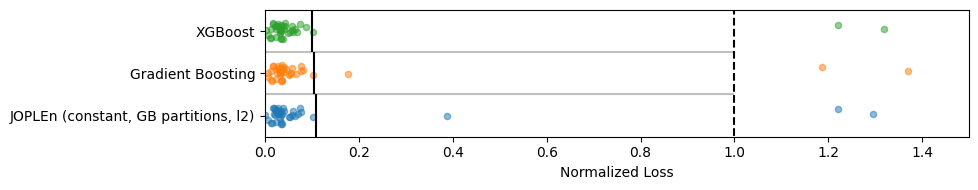

In [8]:
def plot_strip(
    reg_res: dict,
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    only_classification: bool = False,
    only_continuous: bool = False,
):
    """
    Create a strip plot based on the list of y-values.
    """
    x_values = []
    y_labels = []

    def score(vv: dict, only_classification: bool):
        # print(vv)
        if only_classification:
            return vv["metadata"]["test"]["zo_loss"] / vv["dummy_metadata"]["zo_loss"]
        else:
            return vv["test_score"] / vv["dummy_loss"]

    rescaled_res = {
        k: {
            kk: score(vv, only_classification)
            for kk, vv in v.items()
            if kk in classification_dataset_names
            and vv["contains_categorical"] != only_continuous
        }
        for k, v in reg_res.items()
    }

    rescaled_res = {k: v for k, v in rescaled_res.items() if len(v) > 0}

    mean_res = {k: np.mean(list(v.values())) for k, v in rescaled_res.items()}

    sorted_dict = {k: rescaled_res[k] for k in sorted(mean_res, key=mean_res.get)[::-1]}

    for k, v in sorted_dict.items():
        x_values.append(v.values())
        y_labels.append(k)

    fig, ax = plt.subplots(figsize=(10, len(rescaled_res) * 2 / 3), **plot_kwargs)

    for x_idx, val in enumerate(x_values):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in val]
        ax.scatter(val, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim() if only_classification else (0, 1)

    for x_idx, val in enumerate(x_values[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    # plot vertical line for mean for each model
    means = [np.mean(list(val)) for val in x_values]
    for x_value, mean in zip(range(len(x_values)), means):
        ax.vlines(mean, x_value - 1 / 2, x_value + 1 / 2, color="k")

    ax.set_xlim(x_lim)

    print({k: v for k, v in zip(y_labels, means)})

    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)

    if not only_classification:
        ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")

    ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

    plt.xlabel("Normalized Loss")

    plt.tight_layout()

    return ax, means


ONLY_CLASSIFICATION = False
ONLY_CONTINUOUS = False

ax, means = plot_strip(
    reg_res,
    scatter_kwargs={"alpha": 0.5, "s": 20},
    only_classification=ONLY_CLASSIFICATION,
    only_continuous=ONLY_CONTINUOUS,
)

plt.xlim(0, 1 if ONLY_CLASSIFICATION else 1.5)

plt.savefig(PLOT_PATH / "reg_strip.png", dpi=300)

plt.show()

In [9]:
# compute non-parametic distribution test
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

joplen, gb, rf = [], [], []

for k, v in reg_res["JOPLEn (constant, GB partitions, l2)"].items():
    if k in reg_res["Gradient Boosting"]:
        if (k in classification_dataset_names) != ONLY_CLASSIFICATION:
            continue

        dummy_loss = v["dummy_loss"] if ONLY_CLASSIFICATION else 1
        joplen.append(v["test_score"] / dummy_loss)
        gb.append(reg_res["Gradient Boosting"][k]["test_score"] / dummy_loss)
        rf.append(reg_res["Random forest"][k]["test_score"] / dummy_loss)

joplen = np.array(joplen)
gb = np.array(gb)

print(wilcoxon(joplen, gb, alternative="less"))
print(wilcoxon(gb, rf, alternative="less"))

KeyError: 'Random forest'

In [ ]:
plt.scatter(ours, theirs)
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlabel("JOPLEn")
plt.ylabel("Gradient Boosting")
plt.tight_layout()
plt.show()

NameError: name 'ours' is not defined

In [ ]:
datasets = list(list(rescaled_res.values())[0].keys())

ratio = ours / theirs
args = np.argsort(ratio)[::-1]

plt.scatter(range(len(ratio)), ratio[args])
plt.hlines(1, 0, len(ratio), color="k", linestyle="--")

plt.xlabel("Dataset")
plt.ylabel("JOPLEn / Gradient Boosting")

plt.show()

print("We do much worse on these datasets")
print([datasets[i] for i in args[:2]])

NameError: name 'rescaled_res' is not defined

- [192_vineyard](https://github.com/EpistasisLab/pmlb/blob/master/datasets/192_vineyard/metadata.yaml): Small dataset, 52 samples, 2 features. May be that we just needed to use a better GB model for selecting splits
- 645_fri_c3_500_50: Not sure what's wrong with this dataset

In [ ]:
shapes = []

for ds_path in reg_datasets:
    if ds_path.name in EXCLUDE:
        continue

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    shapes.append(x_train.shape[1])

plt.hist(shapes, bins=20)
plt.ylabel("# features")
plt.xlabel("Frequency")
plt.show()